In [15]:
import numpy as np
import scipy
from scipy.linalg import sqrtm
import scipy.sparse as sp
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lanczos import lanczos_algorithm, process_adjacency_matrix
from pygcn.pygcn.utils import load_data, encode_onehot, normalize, accuracy
from nn.layers import SpectralConv
from pygcn.pygcn.layers import GraphConvolution

from pyGAT.layers import GraphAttentionLayer

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cora data load

In [14]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(path = '../../pygcn/data/cora/')
A = adj.detach().to_dense().numpy()

Loading cora dataset...


## Data processing

In [16]:
A.sum(0)[:15]

array([0.8333334 , 0.53125   , 0.52758074, 0.78333336, 0.8333334 ,
       0.625     , 0.5694444 , 0.5833333 , 0.8000001 , 1.2416667 ,
       0.7519842 , 0.61904764, 0.61025643, 0.7166667 , 4.8333335 ],
      dtype=float32)

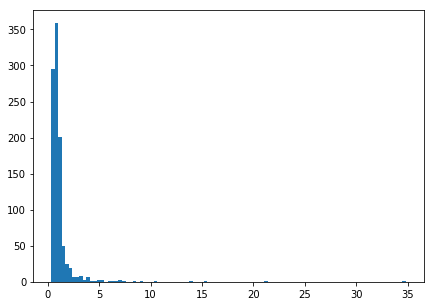

In [17]:
plt.hist(A.sum(0)[:1000], bins=100)
plt.show()

In [7]:
k=1000
S, V, R = process_adjacency_matrix(A, k) #need only this one
S, Q, T = process_adjacency_matrix(A, k, ritz=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.87it/s]


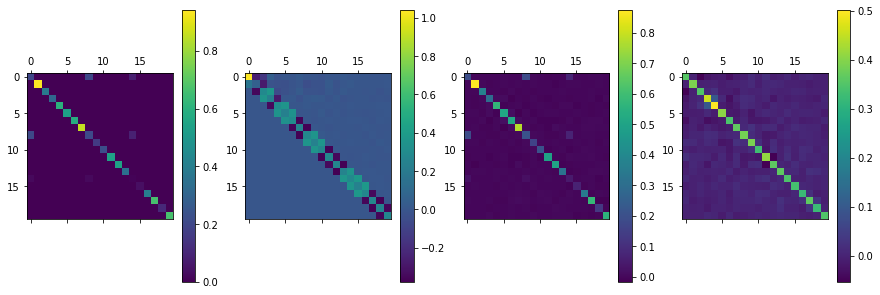

In [8]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
m1 = ax1.matshow(S[:20,:20])
m2 = ax2.matshow(T[:20,:20])
m3 = ax3.matshow((Q@T@Q.T)[:20,:20])
m4 = ax4.matshow((V@R@V.T)[:20,:20])
f.colorbar(m1, ax=ax1)
f.colorbar(m2, ax=ax2)
f.colorbar(m3, ax=ax3)
f.colorbar(m4, ax=ax4)

## Training

In [10]:
class LanczosConvNet(nn.Module):
    def __init__(self, k, feat_dim, num_classes, short_scales, long_scales, out_features = 1000, dropout = 0.6, alpha = 0.2, nheads = 8):
        super(LanczosConvNet, self).__init__()
        self.spectral_conv = SpectralConv(feat_dim, out_features, k, short_scales, long_scales, mlp_layers_number=1)
        self.dropout = dropout
        
        self.attentions = [GraphAttentionLayer(out_features, int(512 / nheads), dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)
            
        self.out_att = GraphAttentionLayer(512, num_classes, dropout=dropout, alpha=alpha, concat=False)
                                
    def forward(self, adj, X, S, V, R):
        
        features = self.spectral_conv(X, S, V, R)
        
        features = F.dropout(features, self.dropout, training=self.training)
        features = torch.cat([att(features, adj) for att in self.attentions], dim=1)
        
        features = F.dropout(features, self.dropout, training=self.training)
        features = F.elu(self.out_att(features, adj))
        
        return F.log_softmax(features, dim=1)

In [11]:
n = adj.shape[0]
feat_dim = 1433
short_scales = [1,3,5]
long_scales = [10,20,30]
num_classes = 7
lr = 1e-2

In [12]:
A = torch.Tensor(A).cuda()
X = features.cuda()
S = torch.Tensor(S).cuda()
V = torch.Tensor(V).cuda()
w = torch.Tensor(np.diag(R)).cuda()
labels = labels.cuda()

In [13]:
loss_train_vals = []
loss_test_vals = []
acc_train_vals = []
acc_test_vals = []

model = LanczosConvNet(k, feat_dim,  num_classes, short_scales, long_scales).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

def train(epoch, eval_epoch=3):
    model.train()
    optimizer.zero_grad()
    output = model(A, X, S, V, w)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    model.eval()
    output = model(A, X, S, V, w)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    
    loss_train_vals.append(loss_train.item())
    loss_test_vals.append(loss_val.item())
    acc_train_vals.append(acc_train.item())
    acc_test_vals.append(acc_val.item())
    
    if epoch > 0 and epoch%eval_epoch == 0:
        clear_output()
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.plot(loss_train_vals, label='train')
        ax1.plot(loss_test_vals, label='test')
        ax1.set_title('loss')
        ax1.legend()
        
        ax2.plot(acc_train_vals, label='train')
        ax2.plot(acc_test_vals, label='test')
        ax2.set_title('accuracy')
        ax2.legend()
        
        plt.show()
        
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss_train_vals[-1]),
              'acc_train: {:.4f}'.format(acc_train_vals[-1]),
              'loss_val: {:.4f}'.format(loss_test_vals[-1]),
              'acc_val: {:.4f}'.format(acc_test_vals[-1]))


def test():
    model.eval()
    output = model(A, X, S, V, w)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

In [ ]:
epochs=80
for epoch in tqdm(range(epochs)):
    train(epoch)

In [ ]:
print("min test loss:", loss_test_vals[np.argmin(acc_test_vals)])
print("max test accuracy:", {max(acc_test_vals)})

- Improvement over baseline ~1% (from 81.3 -> 82.3)

- Run time is significantly greater

- Snapshot of train:

<img src="Cora_attention.png">